In [1]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  64
  On-line CPU(s) list:   0-63
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) Gold 6242 CPU @ 2.80GHz
    CPU family:          6
    Model:               85
    Thread(s) per core:  2
    Core(s) per socket:  16
    Socket(s):           2
    Stepping:            7
    CPU max MHz:         3900.0000
    CPU min MHz:         1200.0000
    BogoMIPS:            5600.00
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss 
                         ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art
                          arch_perfmon pebs bts rep_good nopl xtopology nonstop_
                         tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds

## Das Roofline Modell
Mit der folgenden Funktion können Sie sich das Roofline-Modell für verschiedene Punkte grafisch anzeigen lassen. Bitte beachten Sie, dass die Funktion nicht sehr fehlertolerant ist. Als erster Parameter kann die maximale Leistung der CPU in GFLOPS/s angegeben werden. Der zweite Parameter kann ein Wert oder eine Liste mit der maximalen Bandbreite sein!

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def plot_roofline(pmax, betas):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    I = np.logspace(-2, 3, 100, base=10)
    try:
        for beta in betas:
            P = beta * I
            P[P >= pmax] = pmax
            ax.plot(I, P, label=f"{beta} GB/s")
    except Exception as error:
        P = betas * I
        P[P >= pmax] = pmax
        ax.plot(I, P, label=f"{betas} GB/s")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(10, 1000)
    ax.set_xlim(1e-2, 1e3)
    ax.set_xlabel("FLOPS/Byte")
    ax.set_ylabel("GFLOPs/sec")
    ax.grid(True, "both")
    ax.legend()
    return ax, fig

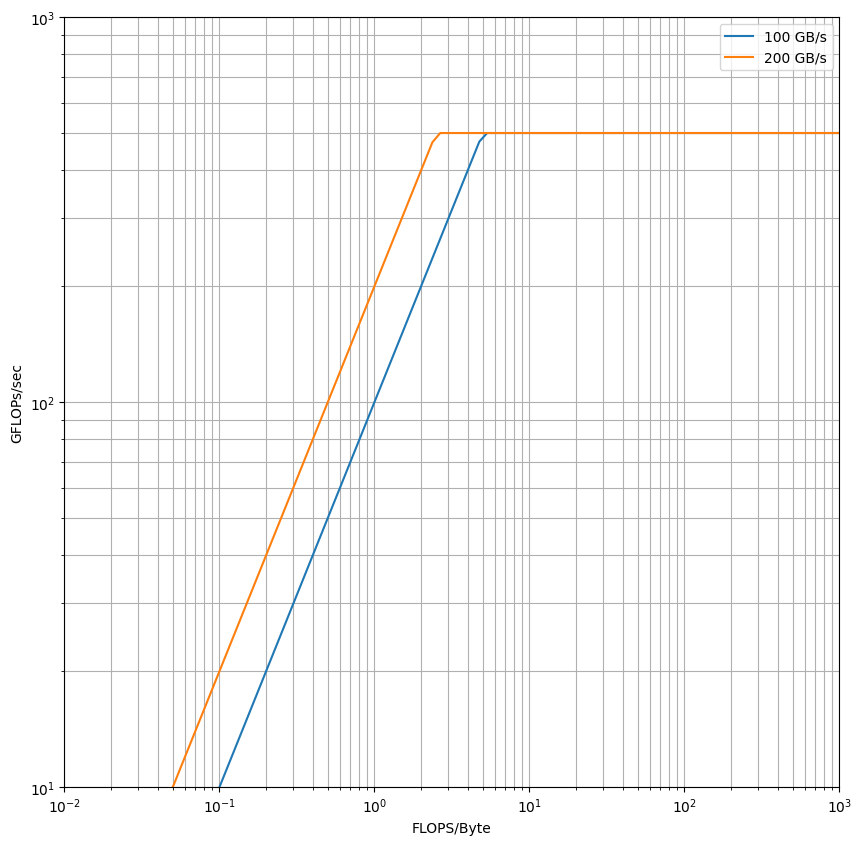

In [3]:
ax, fig = plot_roofline(500, [100, 200])

## Empirische Messungen
Im Folgenden werden zwei in der Praxis und in der wissenschaftlichen Forschung verbreitete Methoden zur empirischen Messung der Speicherbandbreite vorgestellt. Im Zusatzmaterial zu diesem Kurs haben Sie die Möglichkeit, diese Experimente selbst durchzuführen.

Die empirische Bandbreite gibt die maximale Geschwindigkeit an, mit der Daten aus dem Hauptspeicher in den Prozessor geladen werden können. Wenn ein einzelnes Byte aus dem Speicher geholt wird, dauert es einen Zyklus, um es aus einem CPU-Register zu lesen. Ist das Byte nicht im CPU-Register vorhanden, wird es aus dem L1-Cache geholt. Ist es auch dort nicht vorhanden, lädt es der L1-Cache aus dem L2-Cache. Dies setzt sich bis zum Hauptspeicher fort. Das Holen eines einzelnen Bytes direkt aus dem Hauptspeicher kann ca. 400 Taktzyklen in Anspruch nehmen.

Die Zeit, die benötigt wird, um das erste Byte der Daten aus jeder Speicherschicht zu lesen, wird als Speicherlatenz bezeichnet. Befindet sich der Wert in einem höheren Cache-Level, kann er schneller abgerufen werden, bis er aus dieser Cache-Ebene verdrängt wird.

Anstatt jedes Byte einzeln zu laden, was sehr ineffizient wäre, werden beim Laden eines Bytes automatisch mehrere benachbarte Daten (eine sogenannte Cache-Zeile) in den Cache geladen. Dadurch sind aufeinanderfolgende Daten bereits in den Cache-Ebenen verfügbar, was den Zugriff beschleunigt.

Cache-Zeilen, Cache-Größen und die Anzahl der Cache-Ebenen sind so ausgelegt, dass die theoretische Bandbreite des Hauptspeichers möglichst gut ausgenutzt wird. Die Datenübertragungsrate ist beim Laden aufeinanderfolgender Daten am größten.

Zur Messung der Bandbreite verwenden wir zwei Methoden: den *STREAM*-Benchmark und das *Empirical Roofline Toolkit (ERT)*. Der STREAM-Benchmark wurde ursprünglich von John McCalpin um 1995 entwickelt, um die Bedeutung der Speicherbandbreite gegenüber den maximalen FLOPs hervorzuheben.

Der Stream-Benchmark misst die Zeit, die zum Lesen eines großen Datenarrays benötigt wird. Es gibt vier Varianten, abhängig von den Operationen, die die CPU beim Lesen der Daten ausführt: Kopie, Skalierung, Addition und Triade. Während beim Kopieren keine Gleitkommaoperationen durchgeführt werden, werden bei Skalierung und Addition jeweils eine und bei Triade zwei arithmetische Operationen durchgeführt. Jede Variante liefert unterschiedliche Erkenntnisse darüber, wie schnell Daten unter verschiedenen Bedingungen aus dem Hauptspeicher geladen werden können. Bei diesen Tests wird die FLOP-Rate durch die Geschwindigkeit begrenzt, mit der die Daten aus dem Speicher geladen werden.


### Der Stream Benchmark

In [4]:
%%bash
if [ ! -d "./STREAM" ]; then 
    git clone https://github.com/jeffhammond/STREAM --branch master --single-branch
fi

Cloning into 'STREAM'...


In [5]:
!cd STREAM && make stream_c.exe && ./stream_c.exe

gcc -O2 -fopenmp stream.c -o stream_c.exe
-------------------------------------------------------------
STREAM version $Revision: 5.10 $
-------------------------------------------------------------
This system uses 8 bytes per array element.
-------------------------------------------------------------
Array size = 10000000 (elements), Offset = 0 (elements)
Memory per array = 76.3 MiB (= 0.1 GiB).
Total memory required = 228.9 MiB (= 0.2 GiB).
Each kernel will be executed 10 times.
 The *best* time for each kernel (excluding the first iteration)
 will be used to compute the reported bandwidth.
-------------------------------------------------------------
Number of Threads requested = 64
Number of Threads counted = 64
-------------------------------------------------------------
Your clock granularity/precision appears to be 1 microseconds.
Each test below will take on the order of 5811 microseconds.
   (= 5811 clock ticks)
Increase the size of the arrays if this shows that
you are not

## Das Empirical Roofline Toolkit

Das "Empirical Roofline Toolkit" wurde vom Lawrence Berkeley National Laboratory entwickelt. Es dient zur Erfassung und Visualisierung von Messwerten für das Roofline-Modell.



Mit diesem Skript kann das Modell selbst ausgeführt werden. Die Parameter können in der Datei *Hopper2023* angepasst werden.

In [6]:
%%bash
if [ ! -d "./cs-roofline-toolkit" ]; then 
    git clone https://bitbucket.org/berkeleylab/cs-roofline-toolkit --branch master --single-branch
    # fix for "error: expected ')' before 'PRIu64'"
    sed '3i\#define __STDC_FORMAT_MACROS' -i cs-roofline-toolkit/Empirical_Roofline_Tool-1.1.0/Kernels/kernel1.h
fi

Cloning into 'cs-roofline-toolkit'...


In [7]:
# Lösche die alten Ergebnisse (kann auch auskommentiert werden)
!rm -rf Results.hopper
# Starte das Toolkit mit der Konfig-Datei Hopper2023!
!python cs-roofline-toolkit/Empirical_Roofline_Tool-1.1.0/ert Hopper2023 --no-gnuplot
# Stelle die Ergebnisse da!
from display_roofline import display


Reading configuration from 'Hopper2023'...
  Making new results directory, Results.hopper...
    Making new run directory, 'Results.hopper/Run.001'...

FLOP count 1...
  Building ERT core code...
  Running ERT core code...
    OpenMP 1
    OpenMP 8
    OpenMP 16
  Processing results...

FLOP count 16...
  Building ERT core code...
  Running ERT core code...
    OpenMP 1
    OpenMP 8
    OpenMP 16
  Processing results...

Gathering the final roofline results...

+-------------------------------------------------
| Empirical roofline database: 'Results.hopper/Run.001/roofline.json'
+-------------------------------------------------



Schauen wir uns die Ergebnisse genauer an. Wir beginnen mit einem Thread und führen pro Zugriff eine Fließkommaoperation aus. Anschließend werden die Ergebnisse dargestellt.

Hinweis: Es kann vorkommen, dass L4- oder L5-Caches identifiziert werden. Wie bereits mit `lscpu` festgestellt, sind diese Caches auf diesem Rechner nicht vorhanden. Es ist wahrscheinlich, dass es sich um Messfehler handelt oder dass Unterschiede durch NUMA-Effekte verursacht werden. Solche Werte sollten ignoriert werden.

Reading Results.hopper/Run.001/FLOPS.001/OpenMP.0001/sum


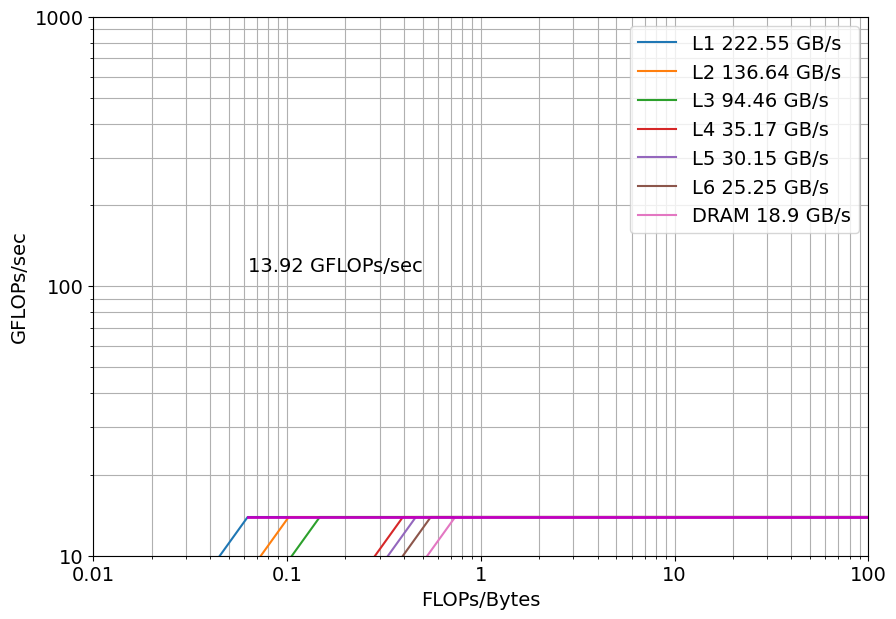

In [8]:
display(threads=1, flops=1)

Wir sehen, dass wir mit nur einem Thread und einer Operation eine recht geringe Speicherbandbreite erreichen. Wir kommen schnell in einen Bereich, in dem nicht die Bandbreite, sondern die Latenz unsere Leistung begrenzt. Dies ist der flache Bereich im Diagramm. Wir wollen nun die Anzahl der Float-Operationen pro Speicherzugriff erhöhen:

Reading Results.hopper/Run.001/FLOPS.016/OpenMP.0001/sum


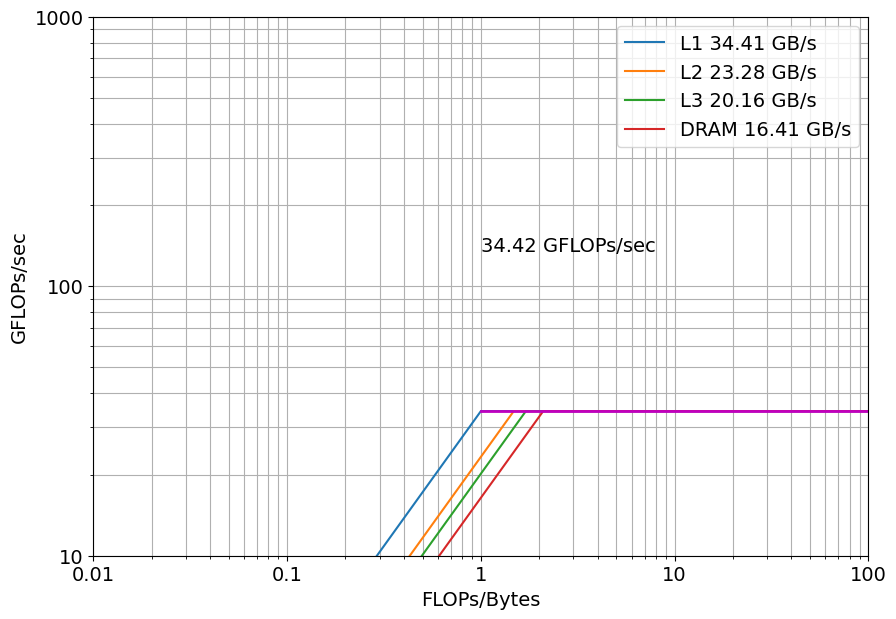

In [9]:
display(threads=1, flops=16)

Wie man sieht, wird die Bandbreite kaum größer (im Gegenteil, sie wird kleiner). Allerdings können deutlich mehr Operationen pro Sekunde durchgeführt werden, die Performance steigt. Wenn man mehrere Operationen auf den gleichen Daten durchführt, kann man oft direkt von den Registern auf die Daten zugreifen und muss nicht mehr auf den Speicher zugreifen.

Reading Results.hopper/Run.001/FLOPS.016/OpenMP.0016/sum


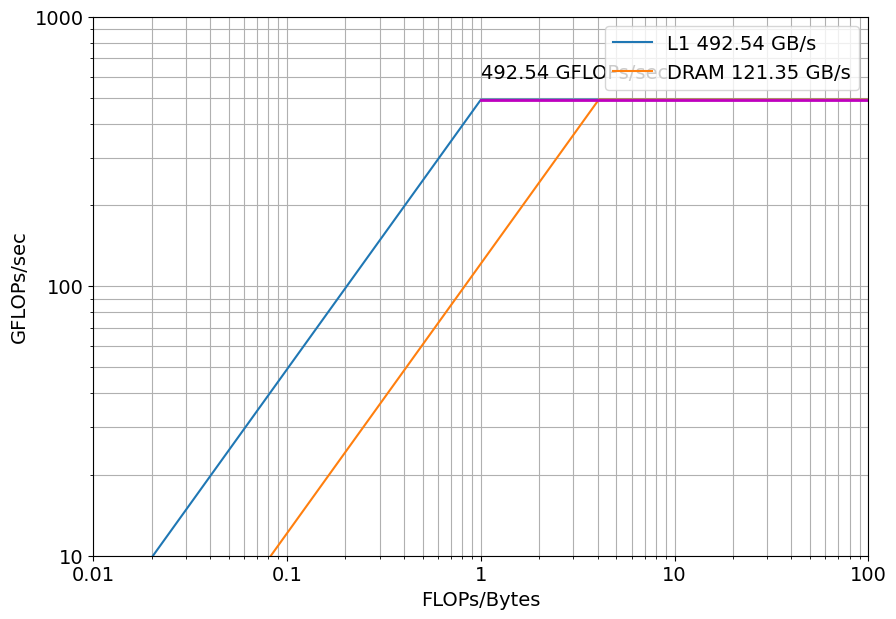

In [10]:
display(threads=16, flops=16)

Wie wir nun sehen, haben wir eine deutlich höhere Speicherbandbreite und Performance als mit nur einem Thread. Dies zeigt, dass mehrere Threads nicht nur für die beste Performance, sondern auch für eine hohe Speicherbandbreite erforderlich sind. 